# Task F

In [31]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

from models import *
from utils import * 
from optimizers import * 
from definitions import SAVE_PATH

# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)
outputs = z.ravel()

# Split dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, outputs, test_size=0.2, random_state=20)

# Get polynomial features
degree = 5
poly = PolynomialFeatures(degree, include_bias=True)
x_train = poly.fit_transform(x_train)
x_test = poly.transform(x_test)

# Scale data (leave out intercept/bias)
scaler = StandardScaler()
x_train[:, 1:] = scaler.fit_transform(x_train[:, 1:])
x_test[:, 1:] = scaler.transform(x_test[:, 1:])

print(x_train.shape)

(320, 21)


### Number of epochs

First, consider the simple case of a linear regression model that is trained using standard sgd. By using a small learning rate, we'll analyze the number of epochs.

Yielded r2 score of: 0.91


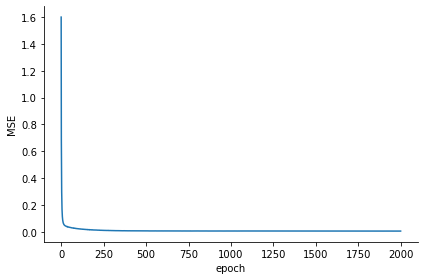

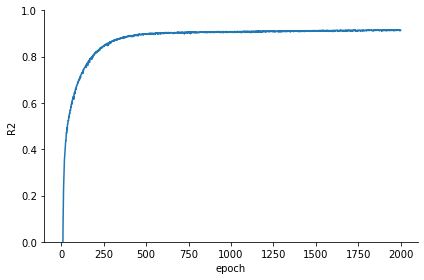

<AxesSubplot:xlabel='epoch', ylabel='R2'>

In [11]:
# Define parameters
epochs = 2000 
lr = 0.001
batch_size = 1

# Instantiate optimizer and model
optimizer = SGD(lr=lr)
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')

# Iterate over epochs
mse_losses = []
r2_scores = []
for _ in range(epochs):

    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)

    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)

    # Get error
    y_hat = model.predict(x_test)
    mse = MSE(y_test, y_hat)
    r2 = R2(y_test, y_hat)
    
    # Append
    mse_losses.append(mse)
    r2_scores.append(r2)

print('Yielded r2 score of: {}'.format(np.round(r2_scores[-1], 2)))
plot_metric(y=mse_losses, show=True, save=True, x_label='epoch', y_label='MSE', name='f_mse_sgd_linear')
plot_metric(y=r2_scores, y_limit=[0, 1], show=True, save=True, x_label='epoch', y_label='R2', name='f_r2_sgd_linear')

### Hyperparameter analysis

Now, we'll study the different hyperparameters in a structured way.

#### Learning rate, batch size and number of epochs

Analysis of different learning rates, batch sizes and epochs.

/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)
/Users/frederikrogge/Software/compsci-project/Notebooks/optimizers.py:67: RuntimeWarning: invalid value encountered in subtract
  parameters = parameters - self.lr * gradient
/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)


Results for 500 epochs


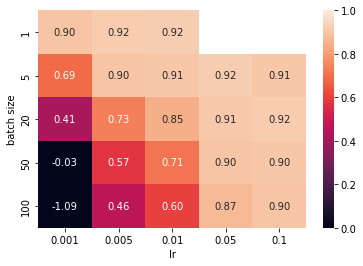

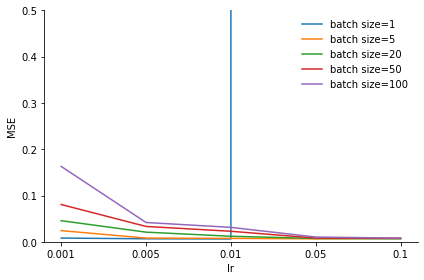

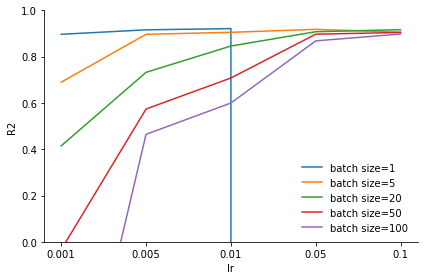

/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)
/Users/frederikrogge/Software/compsci-project/Notebooks/optimizers.py:67: RuntimeWarning: invalid value encountered in subtract
  parameters = parameters - self.lr * gradient
/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)


Results for 2000 epochs


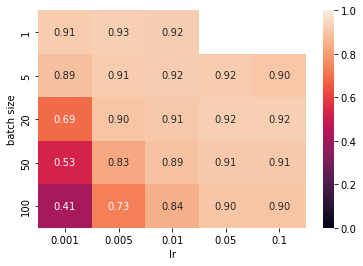

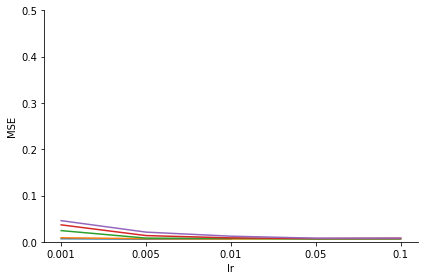

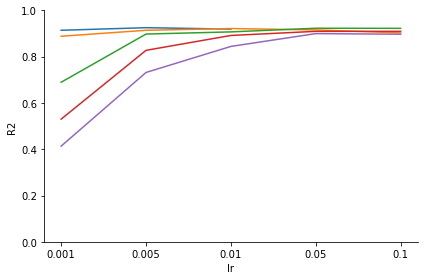

/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)
/Users/frederikrogge/Software/compsci-project/Notebooks/optimizers.py:67: RuntimeWarning: invalid value encountered in subtract
  parameters = parameters - self.lr * gradient
/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)


Results for 5000 epochs


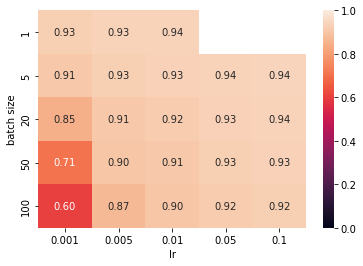

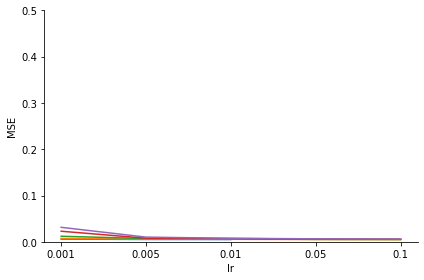

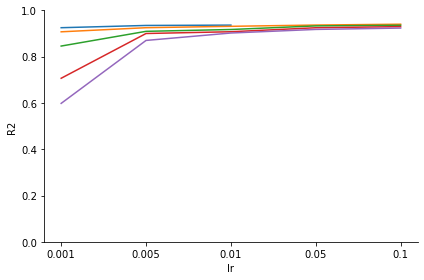

/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)
/Users/frederikrogge/Software/compsci-project/Notebooks/optimizers.py:67: RuntimeWarning: invalid value encountered in subtract
  parameters = parameters - self.lr * gradient
/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)


Results for 10000 epochs


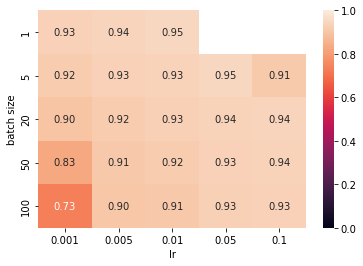

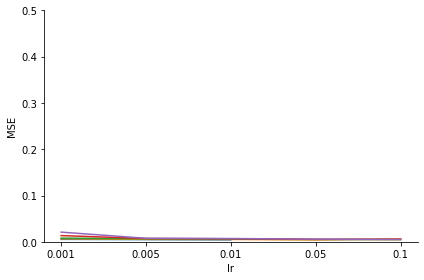

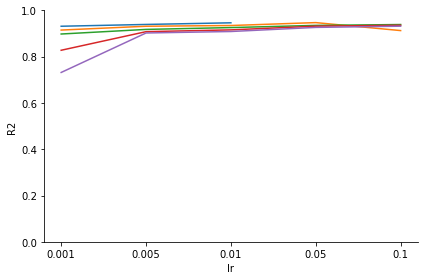

In [15]:
# Define parameters
n_epochs = [500, 2000, 5000, 10000]
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
batch_sizes = [1, 5, 20, 50, 100]

# Iterate over different number of epochs
for i, epochs in enumerate(n_epochs):
    
    # Iterate over different batch sizes 
    all_losses = []
    all_scores = []
    for batch_size in batch_sizes:

        mse_losses = []
        r2_scores = []
        for lr in lrs:

            # Instantiate model and optimizer
            model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
            optimizer = SGD(lr=lr)

            # Train model
            model.train(x_train, y_train, optimizer, batch_size, epochs)

            y_hat = model.predict(x_test)
            mse = MSE(y_test, y_hat)
            r2 = R2(y_test, y_hat)

            # Append
            mse_losses.append(mse)
            r2_scores.append(r2)

        all_losses.append(mse_losses)
        all_scores.append(r2_scores)
        
    df = pd.DataFrame(np.array(all_scores), index=batch_sizes, columns=lrs)
    df = df.mask(df < -100)
    heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".2f",)
    plt.xlabel('lr')
    plt.ylabel('batch size')
    fig = heatmap.get_figure()
    fig.savefig(os.path.join(SAVE_PATH, 'f_heatmap_sgd_linear_lr-batch_{}epoch'.format(epochs)), dpi=300, transparent=True, bbox_inches='tight')

    print('Results for {} epochs'.format(epochs))
    legend = ['batch size='+str(batch_size) for batch_size in batch_sizes] if i == 0 else None   
    plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, y_limit=[0, 0.5], show=True, save=True, x_label='lr', y_label='MSE', 
                name='f_mse_sgd_linear_lr-batch_{}epoch'.format(epochs), legend=legend)

    plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, y_limit=[0, 1], show=True, save=True, x_label='lr', y_label='R2', 
                name='f_r2_sgd_linear_lr-batch_{}epoch'.format(epochs), legend=legend)

#### Exponentially decaying learning rate

Here, we will study the effect of an exponentially decaying learning rate.

/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: overflow encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)
/Users/frederikrogge/Software/compsci-project/Notebooks/optimizers.py:67: RuntimeWarning: invalid value encountered in subtract
  parameters = parameters - self.lr * gradient
/Users/frederikrogge/Software/compsci-project/Notebooks/models.py:192: RuntimeWarning: invalid value encountered in matmul
  grad = X.T @ (X @ self.beta + self.intercept - Y)


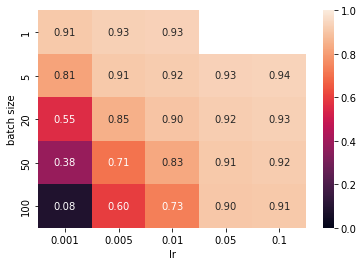

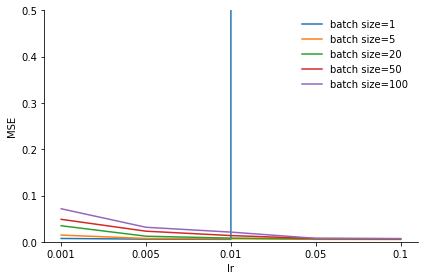

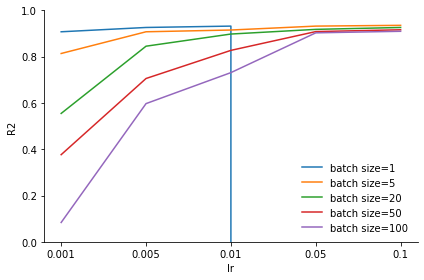

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [38]:
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
batch_sizes = [1, 5, 20, 50, 100]
epochs = 5000
k = 0.001

# Iterate over different batch sizes 
all_losses = []
all_scores = []
for batch_size in batch_sizes:

    mse_losses = []
    r2_scores = []
    for lr in lrs:

        # Instantiate model, lr scheduler and optimizer
        model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
        optimizer = SGD(lr=lr)
        lr_scheduler = ExpLearningScheduler(lr, k=k)
            
        # Train model
        model.train(x_train, y_train, optimizer, batch_size, epochs, lr_scheduler)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)

    all_losses.append(mse_losses)
    all_scores.append(r2_scores)

df = pd.DataFrame(np.array(all_scores), index=batch_sizes, columns=lrs)
df = df.mask(df < -100)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".2f",)
plt.xlabel('lr')
plt.ylabel('batch size')
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'f_heatmap_sgd_linear_lr-sc_lr-batch'), dpi=300, transparent=True, bbox_inches='tight')

legend = ['batch size='+str(batch_size) for batch_size in batch_sizes] 
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, y_limit=[0, 0.5], show=True, save=True, x_label='lr', y_label='MSE', 
            name='f_mse_sgd_linear_lr-sc_lr-batch', legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, y_limit=[0, 1], show=True, save=True, x_label='lr', y_label='R2', 
            name='f_r2_sgd_linear_lr-sc_lr-batch', legend=legend)

Let's take a look at the learning rate schedule

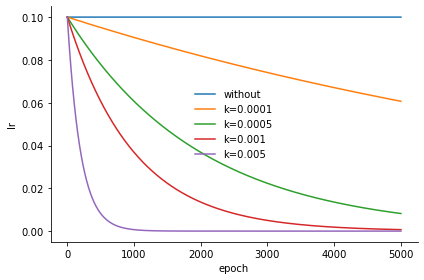

<AxesSubplot:xlabel='epoch', ylabel='lr'>

In [27]:
lr0 = 0.1
ks = [0.0001, 0.0005, 0.001, 0.005]
epochs = 5000
results = []
results.append([lr0 for _ in range(epochs)])
for k in ks:
    lr_scheduler = ExpLearningScheduler(lr0, k=k)
    lrs = []
    lr = lr0
    for _ in range(epochs):
        lrs.append(lr)
        lr = lr_scheduler.update()
    results.append(lrs)
legend = ['without'] + ['k={}'.format(k) for k in ks]
plot_metric(y=results, show=True, save=True, legend=legend, x_label='epoch', y_label='lr', name='f_lr-scheduler')

#### Adam optimizer

Now, we'll do the same except that in this case we'll use the Adam optimizer.

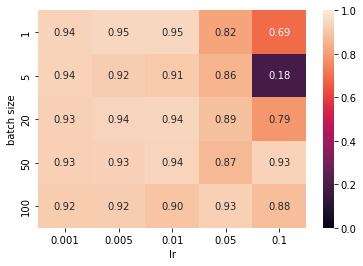

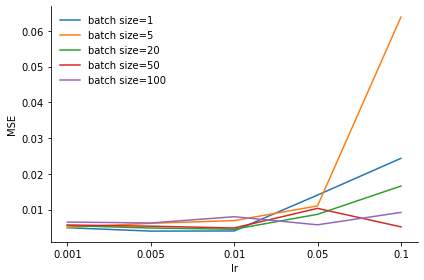

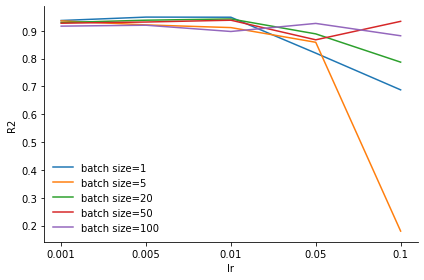

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [21]:
# Define parameters
epochs = 5000
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
batch_sizes = [1, 5, 20, 50, 100]

all_losses = []
all_scores = []
for batch_size in batch_sizes:
    
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        
        # Instantiate model and optimizer
        model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
        optimizer = Adam(lr=lr)
        
        # Train model
        model.train(x_train, y_train, optimizer, batch_size, epochs)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)
    
df = pd.DataFrame(np.array(all_scores), index=batch_sizes, columns=lrs)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".2f",)
plt.xlabel('lr')
plt.ylabel('batch size')
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'f_heatmap_adam_linear_lr-batch_{}epoch'.format(epochs)), dpi=300, transparent=True, bbox_inches='tight')

legend = ['batch size='+str(batch_size) for batch_size in batch_sizes]    
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_adam_linear_lr-batch',
           legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_adam_linear_lr-batch',
           legend=legend)

#### Ridge regression

5000 epochs and a batch size of 5 have shown to work well previously. We'll use these values and study the learning rate and lambda for the Ridge regression case now.

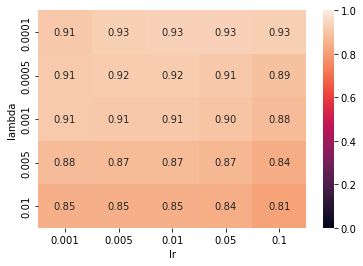

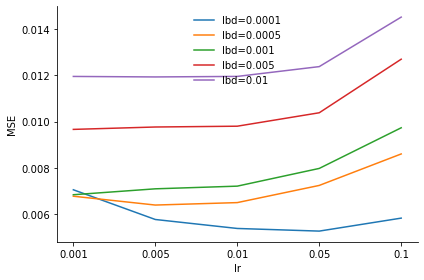

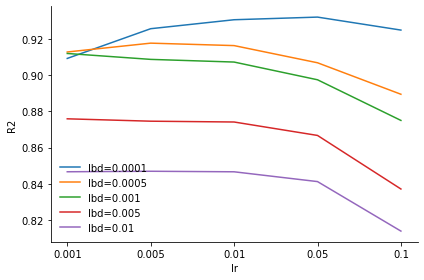

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [22]:
# Define parameters
epochs = 5000
batch_size = 5
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
lbds = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

all_losses = []
all_scores = []
for lbd in lbds:
    
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        
        # Instantiate model and optimizer
        model = RidgeRegression(dimension=x_train.shape[1], random_init=True, reduction='mean', lbd=lbd)
        optimizer = SGD(lr=lr)
        
        # Train model
        model.train(x_train, y_train, optimizer, batch_size, epochs)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)

df = pd.DataFrame(np.array(all_scores), index=lbds, columns=lrs)
df = df.mask(df < -100)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".2f",)
plt.xlabel('lr')
plt.ylabel('lambda')
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'f_heatmap_sgd_ridge_lr-lbd_{}epoch'.format(epochs)), dpi=300, transparent=True, bbox_inches='tight')

legend = ['lbd='+str(lbd) for lbd in lbds]    
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_sgd_ridge_lr-lbd',
           legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_sgd_ridge_lr-lbd',
           legend=legend)

### Convergence considerations

We now want to check which of the algorithms can yield the fastest convergence.

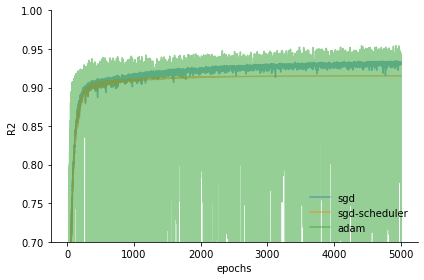

<AxesSubplot:xlabel='epochs', ylabel='R2'>

In [24]:
epochs = 5000
batch_size = 5
all_scores = []

# Normal SGD
lr = 0.01
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
optimizer = SGD(lr=lr)

r2_scores = []
for _ in range(epochs):
    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)
    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)
    # Prediction
    y_hat = model.predict(x_test)
    r2 = R2(y_test, y_hat)
    r2_scores.append(r2)

all_scores.append(r2_scores)

# SGD learning rate decay
lr = 0.01
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
optimizer = SGD(lr=lr)
lr_scheduler = lr_scheduler = ExpLearningScheduler(lr, k=0.001)

r2_scores = []
for _ in range(epochs):
    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)
    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)
    # Update learning rate
    optimizer.lr = lr_scheduler.update()
    # Prediction
    y_hat = model.predict(x_test)
    r2 = R2(y_test, y_hat)
    r2_scores.append(r2)

all_scores.append(r2_scores)

# Adam optimizer
lr = 0.01
batch_size = 5
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
optimizer = Adam(lr=lr)

r2_scores = []
for _ in range(epochs):
    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)
    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)
    # Prediction
    y_hat = model.predict(x_test)
    r2 = R2(y_test, y_hat)
    r2_scores.append(r2)

all_scores.append(r2_scores)


legend = ['sgd', 'sgd-scheduler', 'adam']
plot_metric(y=all_scores, y_limit=[0.7, 1], show=True, save=True, x_label='epochs', y_label='R2', name='f_convergence', legend=legend, alpha=0.5)


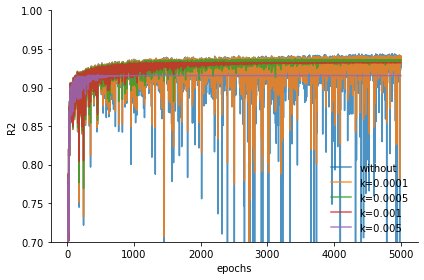

<AxesSubplot:xlabel='epochs', ylabel='R2'>

In [26]:
epochs = 5000
batch_size = 1
ks = [0.0001, 0.0005, 0.001, 0.005]
all_scores = []

# Normal SGD
lr = 0.01
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
optimizer = SGD(lr=lr)

r2_scores = []
for _ in range(epochs):
    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)
    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)
    # Prediction
    y_hat = model.predict(x_test)
    r2 = R2(y_test, y_hat)
    r2_scores.append(r2)

all_scores.append(r2_scores)

# SGD learning rate decay
lr = 0.01

for k in ks:
    model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
    optimizer = SGD(lr=lr)
    lr_scheduler = ExpLearningScheduler(lr, k=k)

    r2_scores = []
    for _ in range(epochs):
        # Generate batches
        x_batches, y_batches = generate_batches(x_train, y_train, batch_size)
        # Iterate through batches
        for x, y in zip(x_batches, y_batches):
            # Determine the gradient for this batch
            gradient = model.gradient(x, y)
            # Update parameters using optimizer
            model.beta = optimizer.update(model.beta, gradient)
        # Update learning rate
        optimizer.lr = lr_scheduler.update()
        # Prediction
        y_hat = model.predict(x_test)
        r2 = R2(y_test, y_hat)
        r2_scores.append(r2)

    all_scores.append(r2_scores)

# Adam optimizer
lr = 0.005
batch_size = 10
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
optimizer = Adam(lr=lr)

legend = ['without'] + ['k={}'.format(k) for k in ks]
plot_metric(y=all_scores, y_limit=[0.7, 1], show=True, save=True, x_label='epochs', y_label='R2', name='f_convergence2', legend=legend, alpha=0.8)

#### Added noise

In [36]:
y_train_noise = y_train + np.random.normal(scale=0.01)
y_test_noise = y_test + np.random.normal(scale=0.01)

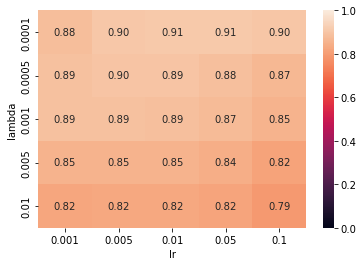

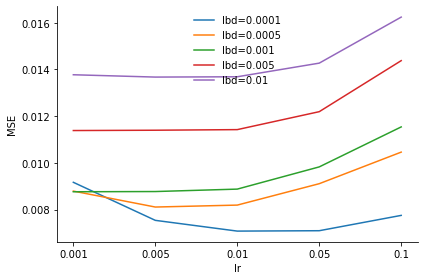

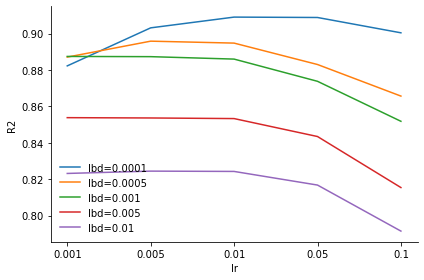

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [37]:
# Define parameters
epochs = 5000
batch_size = 5
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
lbds = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

all_losses = []
all_scores = []
for lbd in lbds:
    
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        
        # Instantiate model and optimizer
        model = RidgeRegression(dimension=x_train.shape[1], random_init=True, reduction='mean', lbd=lbd)
        optimizer = SGD(lr=lr)
        
        # Train model
        model.train(x_train, y_train_noise, optimizer, batch_size, epochs)

        y_hat = model.predict(x_test)
        mse = MSE(y_test_noise, y_hat)
        r2 = R2(y_test_noise, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)

df = pd.DataFrame(np.array(all_scores), index=lbds, columns=lrs)
df = df.mask(df < -100)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".2f",)
plt.xlabel('lr')
plt.ylabel('lambda')
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'f_heatmap_sgd_ridge_noise_lr-lbd_{}epoch'.format(epochs)), dpi=300, transparent=True, bbox_inches='tight')

legend = ['lbd='+str(lbd) for lbd in lbds]    
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_sgd_ridge_noise_lr-lbd',
           legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_sgd_ridge_noise_lr-lbd',
           legend=legend)

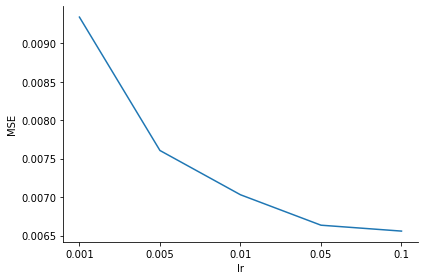

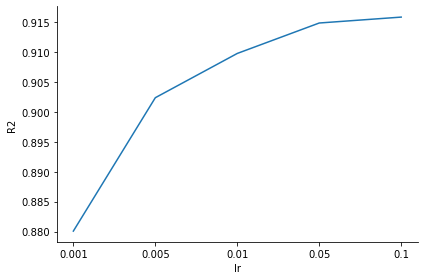

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [40]:
# Define parameters
epochs = 5000
batch_size = 5
lrs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
    
mse_losses = []
r2_scores = []
for lr in lrs:

    # Instantiate model and optimizer
    model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
    optimizer = SGD(lr=lr)

    # Train model
    model.train(x_train, y_train_noise, optimizer, batch_size, epochs)

    y_hat = model.predict(x_test)
    mse = MSE(y_test_noise, y_hat)
    r2 = R2(y_test_noise, y_hat)

    # Append
    mse_losses.append(mse)
    r2_scores.append(r2)
          
plot_metric(y=mse_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_sgd_linear_noise_lr-lbd')
plot_metric(y=r2_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_sgd_linear_noise_lr-lbd')